In [1]:
import pandas as pd
from matplotlib import pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-uk8cgmfj because the default path (/home/jedrz/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df = pd.read_csv("../results/spacy/spacy_train_metrics_kpwr__default.csv")
df.head()

,E,#,LOSS TRANS,LOSS SPANCAT,SPANS_SC_F,SPANS_SC_P,SPANS_SC_R,SCORE
0,0,0,2269.41,11551.88,0.07,0.03,41.23,0.00
1,2,200,519406.77,5088168.71,0.00,0.00,0.00,0.00
2,4,400,1987.86,924243.31,0.00,0.00,0.00,0.00
3,6,600,62.27,105874.17,25.49,84.28,15.01,0.25
4,8,800,8.71,22700.30,26.86,86.93,15.89,0.27


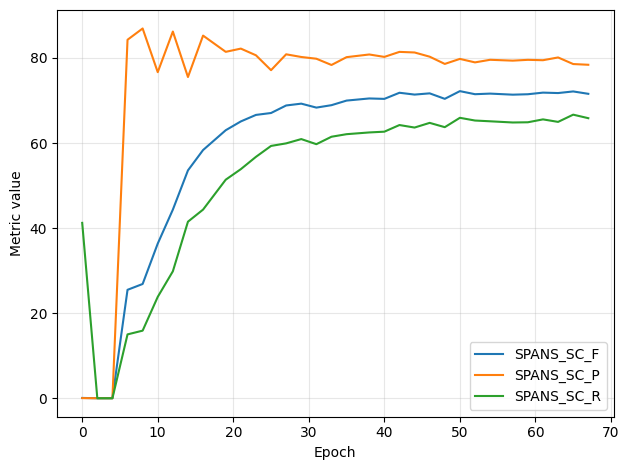

In [3]:
df[["E", "SPANS_SC_F", "SPANS_SC_P", "SPANS_SC_R"]].plot(x="E")
plt.xlabel("Epoch")
plt.ylabel("Metric value")
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

In [4]:
import json

with open("../results/spacy/benchmark_acc_kpwr_test_metrics.json") as f:
    benchmark_acc_metrics = json.load(f)

spancat_benchamrk_metrics_per_type = benchmark_acc_metrics["spans_sc_per_type"]

test_df = pd.DataFrame.from_dict(
    [
        {"Label": label, "f": metrics["f"], "p": metrics["p"], "r": metrics["r"]}
        for label, metrics in spancat_benchamrk_metrics_per_type.items()
    ]
).sort_values(by="f", ascending=False)
test_df.head(10)

,Label,f,p,r
59,nam_eve,1.000000,1.000000,1.000000
39,nam_loc_hydronym_lake,1.000000,1.000000,1.000000
27,nam_oth_currency,0.960000,0.960000,0.960000
6,nam_loc_gpe_country,0.913043,0.923077,0.903226
18,nam_org_political_party,0.906667,0.918919,0.894737
48,nam_loc_land_continent,0.875000,0.777778,1.000000
8,nam_org_group_team,0.867470,0.867470,0.867470
0,nam_liv_person,0.858351,0.892308,0.826884
14,nam_adj_city,0.857143,0.833333,0.882353
15,nam_loc_gpe_admin1,0.825000,0.846154,0.804878


In [5]:
from spacy.lang.pl import Polish
from spacy.tokens import DocBin

In [6]:
nlp = Polish()

In [7]:
train_docbin = DocBin().from_disk("../data/spacy_kpwr/kpwr_spancat_train.spacy")
val_docbin = DocBin().from_disk("../data/spacy_kpwr/kpwr_spancat_val.spacy")
test_docbin = DocBin().from_disk("../data/spacy_kpwr/kpwr_spancat_test.spacy")

In [8]:
from collections import Counter

def count_labels(docbin, vocab, spans_key="sc"):
    counter = Counter()
    for doc in docbin.get_docs(vocab):
        c = Counter([span.label_ for span in doc.spans[spans_key]])
        counter.update(c)
    return counter


train_labels = count_labels(train_docbin, nlp.vocab)
val_labels = count_labels(val_docbin, nlp.vocab)
test_labels = count_labels(test_docbin, nlp.vocab)

In [9]:
train_labels.most_common(10)

[('nam_liv_person', 2911),
 ('nam_loc_gpe_city', 1342),
 ('nam_loc_gpe_country', 992),
 ('nam_org_institution', 783),
 ('nam_org_organization', 591),
 ('nam_org_group_team', 464),
 ('nam_adj_country', 453),
 ('nam_org_company', 324),
 ('nam_pro_media_periodic', 299),
 ('nam_fac_road', 265)]

In [10]:
labels_df = pd.DataFrame.from_dict(
    {"Split": split} | {label: count for label, count in counter.items()}
    for split, counter in zip(
        ["train", "val", "test"], [train_labels, val_labels, test_labels]
    )
).fillna(0)
labels_df.head()

,Split,nam_loc_gpe_country,nam_adj_country,nam_org_nation,nam_liv_person,nam_loc_gpe_city,nam_loc_historical_region,nam_loc_hydronym,nam_pro_title_album,nam_pro_brand,...,nam_pro_title_tv,nam_pro_software_game,nam_fac_square,nam_fac_park,nam_loc_hydronym_ocean,nam_loc_gpe_conurbation,nam_pro_award,nam_fac_goe_stop,nam_loc_land,nam_oth_data_format
0,train,992,453,231,2911,1342,50,8.0,29.0,205,...,41,12.0,26,9,6.0,12.0,25,5,10,15
1,val,171,82,34,458,217,9,1.0,7.0,23,...,15,3.0,3,8,0.0,0.0,17,1,1,6
2,test,186,84,47,491,220,13,0.0,0.0,23,...,9,0.0,3,2,1.0,0.0,6,3,1,4


In [16]:
def count_overlapping_spans(docbin, vocab, spans_key="sc"):
    overlapping_spans = 0
    for doc in docbin.get_docs(vocab):
        if doc.spans[spans_key].has_overlap:
            overlapping_spans += 1
    return overlapping_spans


train_overlapping_spans = count_overlapping_spans(train_docbin, nlp.vocab)
val_overlapping_spans = count_overlapping_spans(val_docbin, nlp.vocab)
test_overlapping_spans = count_overlapping_spans(test_docbin, nlp.vocab)

print((
    "Records with overlapping spans:\n"
    f"  Train: {train_overlapping_spans},\n"
    f"  Val: {val_overlapping_spans},\n"
    f"  Test: {test_overlapping_spans}"
))

Records with overlapping spans:
  Train: 0,
  Val: 0,
  Test: 0
